In [1]:
%reset -f
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from rnn_utils import *

In [33]:
import functools
import numpy as npy

import matplotlib.pyplot as plt

import jax
import jax.numpy as np

from jax import jit
from jax import Array
from jax.example_libraries import optimizers as jax_opt
from rnn_utils import *

# Gather the model

In [31]:
loading = "/home/guillaumep/conceptor-aided-recurrent-autoencoder/logs/heart_pp_8/ckpt/params_10001.npz"

In [34]:
params = np.load(loading)
params = dict(params)

In [35]:
C_bias, B_bias = affine_conceptor(0.5)

In [46]:
def forward_esn3d(params, C_bias, B_bias, ut, idx, x_init = None, encoding = True, biased = False, sep = True, y_init = None, noise = 0., interp=-1.):
    """
    Compute the forward pass for each example individually.
    :param params: parameters of the ESN
    :param C_bottleneck: conceptor matrix
    :param ut: input (T, K)
    :param idx: index of the ESN
    :param x_init: initial state of the reservoir
    :param encoding: whether to encode or decode
    :param biased: whether to use conceptor to bias the state
    :param sep: whether to mix the weights or not
    :param y_init: initial output of the reservoir
    :param inp_mix: whether to mix the input with the state in the MLP or not
    """


    # u_clock can be used both for clock and for input (for initialization)
    if x_init is None:
        interp_para = idx
        x_init = (1-interp_para)*params['x_ini0'] + interp_para*params['x_ini1']
    if y_init is None:
        y_init = ut[1]

    if interp != -1.:
        interp_time = ut.shape[0]
    def apply_fun_scan(params, encoding, interp, C_bias, B_bias, xyc, ut):

        x, y, count = xyc 
        if sep:
            interp_para = idx
        else:
            interp_para = (x[0]+interp)
        w_eff = (1-interp_para)*params['w0'] + interp_para*params['w1']
        win_eff = (1-interp_para)*params['win0'] + interp_para*params['win1']
        wout_eff = (1-interp_para)*params['wout0'] + interp_para*params['wout1'] 
        bias_eff = (1-interp_para)*params['bias0'] + interp_para*params['bias1'] 
        bias_out_eff = (1-interp_para)*params['bias_out0'] + interp_para*params['bias_out1'] 
        # w_exp_eff = (1-interp_para)*params['expension0'] + interp_para*params['expension1']


        
        def encode(params, ut, x, y, interp_para):
            x_in = mlp_eff_in_out(params, interp_para, ut, "in", win_eff, bias_eff)[0]          
            x_tanh = np.dot(w_eff, x) + x_in
            x_tanh, x_exp = mlp_eff(params, interp_para, x_tanh)
            x = (1-params["a_dt"])*x + params["a_dt"]*np.tanh(
                    x_tanh)
            return x, x_exp

        def decode(params, ut, x, y, interp_para):
            x_in = mlp_eff_in_out(params, interp_para, y, "in", win_eff, bias_eff)[0]
            x_tanh = np.dot(w_eff, x) + x_in
            x_tanh, x_exp = mlp_eff(params, interp_para, x_tanh)
            x = (1-params["a_dt"])*x + params["a_dt"]*np.tanh(
                x_tanh)
            return x, x_exp


        

        x, x_exp = jax.lax.cond(encoding, encode, decode,
            params, ut, x, y, interp_para
        )
        # x = np.tanh(x) # still required?

        # add a little bit of noise to the state and the input
        # noise along x-axis is directly cancelled
        _, ut = jax.lax.cond(
            encoding,
            lambda x: (x[0] + noise*npy.random.randn(*x[0].shape), x[1] + noise*npy.random.randn(*x[1].shape)),
            lambda x: x,
            (x, ut)
        )
        # project
        if interp != -1.:
            interp_ini = -interp
            interp_end = interp
            interp_range = interp_end - interp_ini
            affine_interp_para = interp_ini + count * interp_range/interp_time
            B_bias = np.array([affine_interp_para, 0, 0])

        if biased:
            x = np.dot(C_bias, x-B_bias) + B_bias #+ np.clip(x-B_bias, -0.01, 0.01)
        # x = B_bias
        # x = np.dot(C_bias, x)
        # x = jax.lax.cond(
        #     False,
        #     lambda x: x,
        #     lambda x: np.dot(C_bias, x-B_bias) + B_bias,
        #     x
        # )
        
        y = mlp_eff_in_out(params, interp_para, x, "out", wout_eff, bias_out_eff)[0]

        xyc = (x,y, count+1)

        return xyc, (y,x,x_exp)

    f = functools.partial(apply_fun_scan, params)
    f = functools.partial(f, encoding) 
    f = functools.partial(f, interp)
    f = functools.partial(f, C_bias)
    f = functools.partial(f, B_bias)
    xyc = (x_init, y_init, 0)
    _, YX = jax.lax.scan(f, xyc, ut)
    return YX    

# Interpolate

In [36]:
ut_train = np.zeros((2,500,2))
idx = np.array([0,1])

In [50]:
y_esn_auto, X_auto, _ = jax.vmap(forward_esn3d,(None, None,0,0,0,None,None,None,None,None, None))(
    params, C_bias, B_bias, ut_train, idx, None, False, True, True, None, 0.)


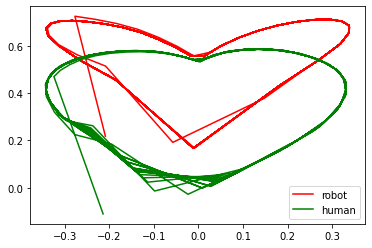

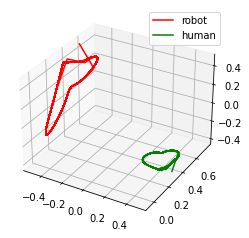

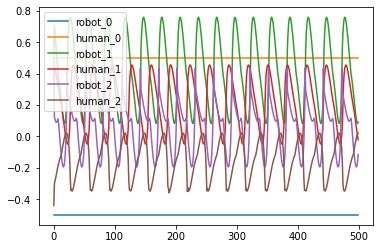

In [51]:
plt.figure()
plt.plot(y_esn_auto[0, :, 0], y_esn_auto[0, :, 1], 'r', label = 'robot')
plt.plot(y_esn_auto[1, :, 0], y_esn_auto[1, :, 1], 'g', label = 'human')
plt.legend()   
plt.show()     
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_auto[0,:,0], X_auto[0,:,1], X_auto[0,:,2], 'r', label = 'robot')
ax.plot(X_auto[1,:,0], X_auto[1,:,1], X_auto[1,:,2], 'g', label = 'human')
plt.legend()
plt.show()

plt.figure()
for i in range(3):
    plt.plot(X_auto[0,:,i], label = f'robot_{i}')
    plt.plot(X_auto[1,:,i], label = f'human_{i}')
plt.legend()
plt.show()

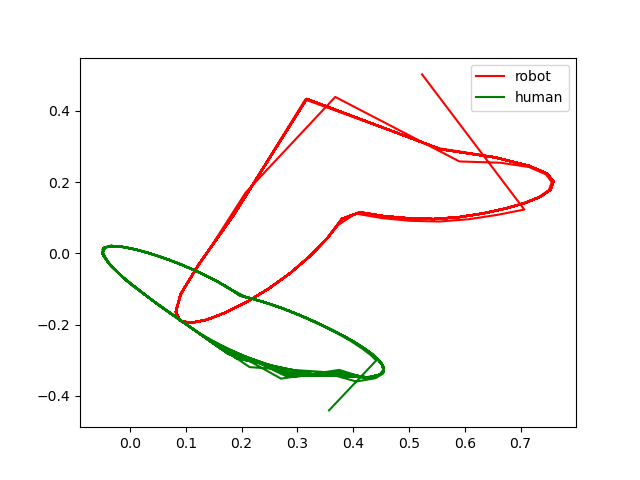

In [186]:
# plt yz plane at x = 0.5 and x = -0.5
plt.figure()
plt.plot(X_auto[0,:,1], X_auto[0,:,2], 'r', label = 'robot')
plt.plot(X_auto[1,:,1], X_auto[1,:,2], 'g', label = 'human')
plt.legend()
plt.show()

In [57]:
ut_train = np.zeros((2,100000,2))

In [ ]:
#def forward_esn3d(params, C_bias, B_bias, ut, idx, x_init = None, encoding = True, biased = False, sep = True, y_init = None, noise = 0.):

In [62]:
y_esn_interp, X_interp, _ = forward_esn3d(
    params, C_bias, B_bias[0], ut_train[0], idx[0], None, False, True, False, None, 0., 0.5)

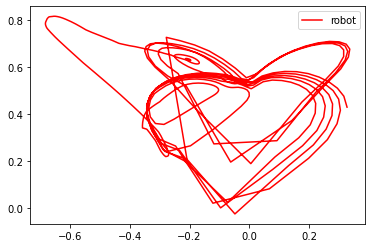

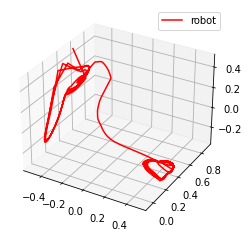

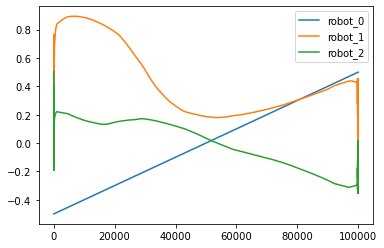

In [63]:
plt.figure()
plt.plot(y_esn_interp[ :, 0], y_esn_interp[:, 1], 'r', label = 'robot')
plt.legend()   
plt.show()     
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_interp[:,0], X_interp[:,1], X_interp[:,2], 'r', label = 'robot')
plt.legend()
plt.show()

plt.figure()
for i in range(3):
    plt.plot(X_interp[:,i], label = f'robot_{i}')
plt.legend()
plt.show()

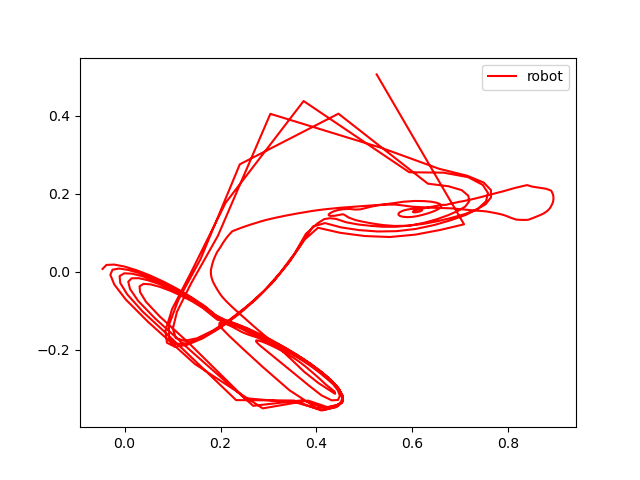

In [185]:
# plot yz plane at x = -0.5 and x = 0.5
plt.figure()
plt.plot(X_interp[:,1], X_interp[:,2], 'r', label = 'robot')
plt.legend()
plt.show()


# Get the vector field

In [113]:
def df_discrete(params):
    def f(x, interp_para=None, biased=False, interp=0.5):
        # interp_para force the interpolation of para
        interp_para = (x[0]+interp)
        w_eff = (1-interp_para)*params['w0'] + interp_para*params['w1']
        win_eff = (1-interp_para)*params['win0'] + interp_para*params['win1']
        wout_eff = (1-interp_para)*params['wout0'] + interp_para*params['wout1'] 
        bias_eff = (1-interp_para)*params['bias0'] + interp_para*params['bias1'] 
        bias_out_eff = (1-interp_para)*params['bias_out0'] + interp_para*params['bias_out1'] 

        # not really true, would need the weight of the previous step
        y = mlp_eff_in_out(params, interp_para, x, "out", wout_eff, bias_out_eff)[0]

        x_in = mlp_eff_in_out(params, interp_para, y, "in", win_eff, bias_eff)[0]
        x_tanh = np.dot(w_eff, x) + x_in
        x_tanh, x_exp = mlp_eff(params, interp_para, x_tanh)
        x_updated = (1-params["a_dt"])*x + params["a_dt"]*np.tanh(
            x_tanh)

        dx = x_updated-x
        dx = dx.at[0].set(0.)
        return dx
    return f

df = df_discrete(params)

df_vmap = jax.vmap(jax.vmap(jax.vmap(df, in_axes=(None, None, None, 0)), in_axes=(None, 0, None)), in_axes=(0, None, None))


In [155]:
x, y, z = np.meshgrid(np.arange(-0.5, 0.6, 0.5),
                  np.arange(-0.8, 1, 0.2),
                  np.arange(-0.8, 1, 0.2), indexing='ij')

data_mesh = np.array([x, y, z])

df_mesh = np.zeros(data_mesh.shape)

for idx_x in range(data_mesh.shape[0]):
    for idx_y in range(data_mesh.shape[1]):
        for idx_z in range(data_mesh.shape[2]):
            df_mesh = df_mesh.at[:,idx_x, idx_y, idx_z].set(df(data_mesh[:,idx_x, idx_y, idx_z]))

In [158]:
x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.8),
                  np.arange(-0.8, 1, 0.2),
                  np.arange(-0.8, 1, 0.2), indexing='ij')

x.shape, y.shape, z.shape

((3, 9, 9), (3, 9, 9), (3, 9, 9))

In [164]:
y[0]

Array([[-8.0000001e-01, -8.0000001e-01, -8.0000001e-01, -8.0000001e-01,
        -8.0000001e-01, -8.0000001e-01, -8.0000001e-01, -8.0000001e-01,
        -8.0000001e-01],
       [-6.0000002e-01, -6.0000002e-01, -6.0000002e-01, -6.0000002e-01,
        -6.0000002e-01, -6.0000002e-01, -6.0000002e-01, -6.0000002e-01,
        -6.0000002e-01],
       [-4.0000004e-01, -4.0000004e-01, -4.0000004e-01, -4.0000004e-01,
        -4.0000004e-01, -4.0000004e-01, -4.0000004e-01, -4.0000004e-01,
        -4.0000004e-01],
       [-2.0000005e-01, -2.0000005e-01, -2.0000005e-01, -2.0000005e-01,
        -2.0000005e-01, -2.0000005e-01, -2.0000005e-01, -2.0000005e-01,
        -2.0000005e-01],
       [-5.9604645e-08, -5.9604645e-08, -5.9604645e-08, -5.9604645e-08,
        -5.9604645e-08, -5.9604645e-08, -5.9604645e-08, -5.9604645e-08,
        -5.9604645e-08],
       [ 1.9999993e-01,  1.9999993e-01,  1.9999993e-01,  1.9999993e-01,
         1.9999993e-01,  1.9999993e-01,  1.9999993e-01,  1.9999993e-01,
         1.

In [135]:
x.shape

(9, 3, 9)

In [126]:
df(data_mesh[:,idx_x, idx_y, idx_z])

Array([ 0.       ,  0.5617537, -0.4278596], dtype=float32)

In [143]:
np.arange(-0.8, 1, 0.2).shape

(9,)

In [148]:
np.arange(-0.5, 0.6, 0.5).shape

(3,)

In [203]:
x, y, z = np.meshgrid(np.arange(-0.5, 0.6, 0.5),
                      np.arange(-0.8, 1, 0.05),
                     np.arange(-0.8, 1, 0.05), indexing='ij')

x.shape, y.shape, z.shape

((3, 36, 36), (3, 36, 36), (3, 36, 36))

In [204]:
x, y, z = np.meshgrid(np.arange(-0.5, 0.6, 0.5),
                  np.arange(-0.8, 1, 0.05),
                  np.arange(-0.8, 1, 0.05), indexing='ij')

data_mesh = np.array([x, y, z])

df_mesh = np.zeros(data_mesh.shape)

for idx_x in range(data_mesh.shape[1]):
    for idx_y in range(data_mesh.shape[2]):
        for idx_z in range(data_mesh.shape[3]):
            df_mesh = df_mesh.at[:,idx_x, idx_y, idx_z].set(df(data_mesh[:,idx_x, idx_y, idx_z]))
x.shape, y.shape, z.shape

((3, 36, 36), (3, 36, 36), (3, 36, 36))

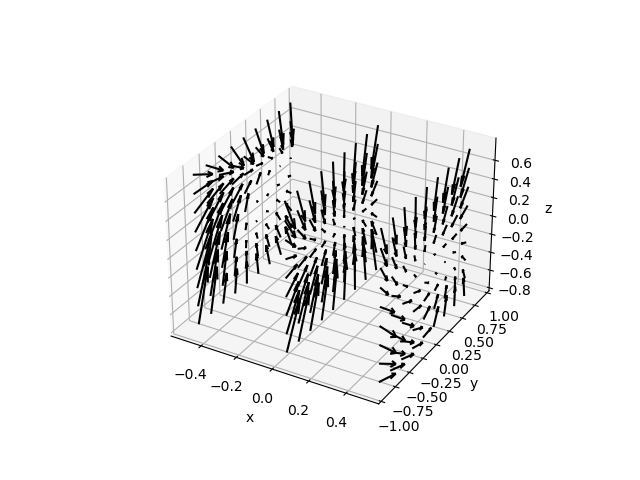

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}


In [193]:
# make interactive plot with widget
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



ax.quiver(x, y, z, df_mesh[0], df_mesh[1], df_mesh[2], length=0.4, color = 'black')
# add legend axis
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_ylim([-1,1])
plt.show()

(0.0, 1.0)

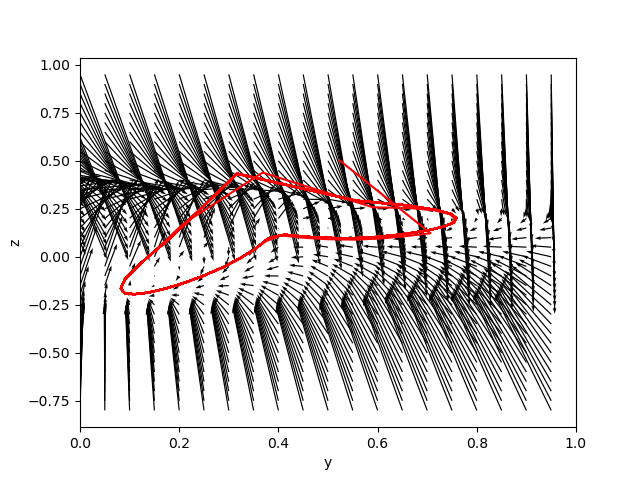

In [226]:
# plot in 2d 
plt.figure()
plt.quiver(y[0], z[0], df_mesh[1,0], df_mesh[2,0],scale=3, color = 'black')
plt.plot(X_auto[0,:,1], X_auto[0,:,2], 'r', label = 'robot')
plt.xlabel('y')
plt.ylabel('z')
plt.xlim([0,1])

Text(0.5, 0, 'y')

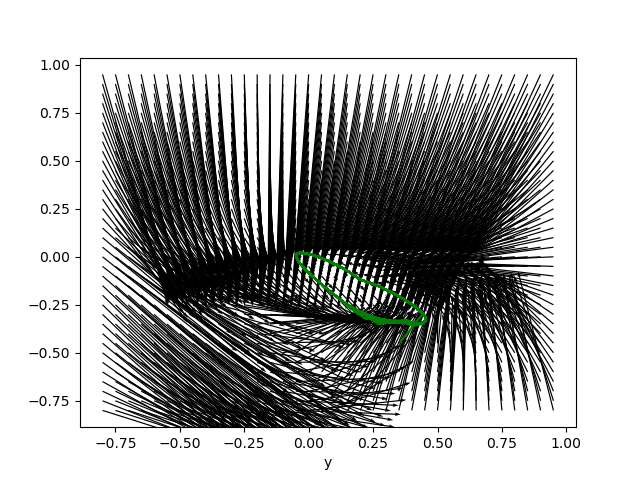

In [224]:
# plot in 2d
plt.figure()
plt.quiver(y[2], z[2], df_mesh[1,2], df_mesh[2,2],scale=2, color = 'black')
plt.plot(X_auto[1,:,1], X_auto[1,:,2], 'g', label = 'human')
plt.plot
plt.xlabel('y')